In [431]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import stan
import torch
 
from scipy.sparse.linalg import svds
from scipy.spatial.distance import pdist, squareform
import auxiliary_stan as auxpl
figsize = auxpl.figsize
fontsize = auxpl.fontsize

In [432]:
sample_id = "V1_Human_Lymph_Node"
path = "results"
patch_size = 26
adata = sc.read("{}/{}{}*{}.h5ad".format(path, sample_id, patch_size, patch_size))
spot_names = adata.obs_names
adata

AnnData object with n_obs × n_vars = 3981 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [433]:
adata_bigan = sc.read("{}/{}_stan_bigan.h5ad".format(path, sample_id))
adata_0 = sc.read("{}/{}_stan_o.h5ad".format(path, sample_id))
adata_ae = sc.read("{}/{}_stan_ae.h5ad".format(path, sample_id))
adata_dino = sc.read("{}/{}_stan_dino.h5ad".format(path, sample_id))
adata_ridge = sc.read("{}/{}_stan_ridge.h5ad".format(path, sample_id))

In [434]:
celltypes = pd.read_csv("data/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("data/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/3846279234.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gc_annotation = pd.read_csv("data/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)


In [435]:
def g_c(adata, celltypes, gc_annotation):
    obs_names = np.intersect1d(celltypes.index, adata.obs_names)
    adata = adata[obs_names]
    celltypes = celltypes.loc[obs_names]
    gc_annotation = gc_annotation.loc[obs_names]
    adata.obsm['celltype'] = celltypes
    adata.obsm['celltype'].columns =  [x.replace('mean_spot_factors','') for x in adata.obsm['celltype'].columns]
    adata.obsm['celltype_raw'] = adata.obsm['celltype'].copy()
    adata.obsm['celltype'] = adata.obsm['celltype'].divide(adata.obsm['celltype'].sum(axis=1), axis=0)
    adata.obs['germinal_center'] = gc_annotation
    adata.obs['germinal_center'] = adata.obs['germinal_center'].map({0: "Other", 1: "GC"})
    return adata
# output of STAN

In [436]:
adata = g_c(adata, celltypes, gc_annotation)
adata_bigan=g_c(adata_bigan, celltypes, gc_annotation)
adata_0=g_c(adata_0, celltypes, gc_annotation)
adata_ae=g_c(adata_ae, celltypes, gc_annotation)
adata_dino=g_c(adata_dino, celltypes, gc_annotation)
adata_ridge=g_c(adata_ridge, celltypes, gc_annotation)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: S

In [437]:
def n(adata):

    sc.pp.normalize_total(adata)
    adata.layers['scaled'] = np.sqrt(adata.to_df())
    
    sc.pp.normalize_total(adata)
    adata.layers['scaled'] = np.sqrt(adata.to_df())

n(adata_bigan)
n(adata_0)
n(adata_ae)
n(adata_dino)
n(adata_ridge)

In [438]:
adata_0.obsm['tfa_stan']

AHR        AR    ARID3A      ARNT     ARNTL  \
AAACAAGTATCTCCCA-1 -0.061237 -0.076209 -0.066981 -0.012806 -0.004280   
AAACAATCTACTAGCA-1 -0.061921 -0.081700 -0.079282 -0.023732  0.064524   
AAACACCAATAACTGC-1 -0.065389 -0.079456 -0.069271 -0.014874  0.000835   
AAACAGAGCGACTCCT-1 -0.072880 -0.068800 -0.075740 -0.015156  0.014109   
AAACAGCTTTCAGAAG-1 -0.078050 -0.092477 -0.080606 -0.023020  0.000150   
...                      ...       ...       ...       ...       ...   
TTGTTTCACATCCAGG-1 -0.073464 -0.079025 -0.080830 -0.014920  0.048681   
TTGTTTCATTAGTCTA-1 -0.063486 -0.069105 -0.069767 -0.017385  0.060468   
TTGTTTCCATACAACT-1 -0.067388 -0.080780 -0.070716 -0.019829  0.030619   
TTGTTTGTATTACACG-1 -0.064792 -0.077695 -0.077569 -0.020497  0.071064   
TTGTTTGTGTAAATTC-1 -0.061275 -0.073710 -0.072571 -0.014041  0.048895   

                       ASCL1     ASCL2      ATF1      ATF2      ATF3  ...  \
AAACAAGTATCTCCCA-1  0.014640 -0.025595  0.021768  0.089126 -0.034523  ...   
AAACAATCTACTAGCA-1 -0.003935 -0.020306  0.037346  0.087394 -0.042596  ...   
AAACACCAATAACTGC-1  0.009106 -0.020946  0.018895  0.086293 -0.026341  ...   
AAACAGAGCGACTCCT-1  0.002678 -0.016021  0.028313  0.080102 -0.024169  ...   
AAACAGCTTTCAGAAG-1  0.005515 -0.017068  0.040846  0.105666 -0.031836  ...   
...                      ...       ...       ...       ...       ...  ...   
TTGTTTCACATCCAGG-1  0.012187 -0.024816  0.026335  0.089035 -0.022660  ...   
TTGTTTCATTAGTCTA-1  0.000383 -0.013730  0.028385  0.089826 -0.034184  ...   
TTGTTTCCATACAACT-1 -0.000306 -0.025332  0.023390  0.091501 -0.029542  ...   
TTGTTTGTATTACACG-1  0.004729 -0.022779  0.033090  0.087010 -0.039325  ...   
TTGTTTGTGTAAATTC-1  0.007558 -0.027936  0.039455  0.093012 -0.031649  ...   

                      ZNF143    ZNF217    ZNF236    ZNF250    ZNF263  \
AAACAAGTATCTCCCA-1 -0.031074 -0.130645 -0.043269 -0.091412  0.011852   
AAACAATCTACTAGCA-1 -0.033577 -0.107106  0.043864 -0.127752 -0.011556   
AAACACCAATAACTGC-1 -0.026572 -0.102706 -0.018884 -0.155272  0.020949   
AAACAGAGCGACTCCT-1 -0.027875 -0.125837  0.002800 -0.169985 -0.000043   
AAACAGCTTTCAGAAG-1 -0.048373 -0.086177 -0.053043 -0.095783 -0.004922   
...                      ...       ...       ...       ...       ...   
TTGTTTCACATCCAGG-1 -0.041343 -0.116214  0.043951 -0.090531  0.006012   
TTGTTTCATTAGTCTA-1 -0.029711 -0.111299 -0.027198 -0.122486  0.006657   
TTGTTTCCATACAACT-1 -0.032404 -0.119604 -0.030523 -0.145742  0.005981   
TTGTTTGTATTACACG-1 -0.036773 -0.108286 -0.035526 -0.132877 -0.002242   
TTGTTTGTGTAAATTC-1 -0.046051 -0.183032  0.016412 -0.132894  0.005227   

                      ZNF281    ZNF384    ZNF711     ZNF76     ZNF84  
AAACAAGTATCTCCCA-1  0.027137  0.026902 -0.351841 -0.120973  0.181811  
AAACAATCTACTAGCA-1  0.133818  0.031365 -0.440595 -0.157639  0.167454  
AAACACCAATAACTGC-1  0.097783  0.029877 -0.359504 -0.115568  0.136105  
AAACAGAGCGACTCCT-1  0.123149  0.017473 -0.305830 -0.150625  0.035934  
AAACAGCTTTCAGAAG-1  0.059928  0.027100 -0.319729 -0.134399  0.215263  
...                      ...       ...       ...       ...       ...  
TTGTTTCACATCCAGG-1  0.073156  0.028459 -0.304660 -0.128404  0.153186  
TTGTTTCATTAGTCTA-1  0.069220  0.027054 -0.392707 -0.134728  0.101606  
TTGTTTCCATACAACT-1  0.085986  0.023142 -0.349065 -0.127231  0.131671  
TTGTTTGTATTACACG-1  0.060701  0.018408 -0.374400 -0.143301  0.101697  
TTGTTTGTGTAAATTC-1  0.036390  0.033169 -0.343733 -0.138148  0.111609  

[3979 rows x 234 columns]

In [439]:
adata_0

AnnData object with n_obs × n_vars = 3979 × 8926
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'pixel', 'pred_cor_stan_AE', 'pred_cor_stan_origin', 'pred_cor_stan_BIGAN', 'pred_cor_ridge', 'germinal_center'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'fold', 'pred_cor_stan_AE', 'pred_cor_stan_origin', 'pred_cor_stan_BIGAN', 'pred_cor_ridge'
    uns: 'spatial', 'tf_names'
    obsm: 'kernel', 'pixel', 'spatial', 'tfa_stan', 'celltype', 'celltype_raw'
    varm: 'gene_tf'
    layers: 'raw', 'scaled'
    obsp: 'kernel', 'pw_dist'

In [440]:
#把adata原数值替换为.obsm['tfa_stan']
adata_tfa_0 = adata_0.copy()
adata_tfa_bigan = adata_bigan.copy()
adata_tfa_ae = adata_ae.copy()
adata_tfa_dino = adata_dino.copy()
adata_tfa_ridge = adata_ridge.copy()


In [441]:
import pandas as pd
import anndata

def get_activation(adata):
    # 提取 'tfa_stan' 矩阵
    tfa_stan = adata.obsm['tfa_stan']
    
    # 创建新的变量名称
    var_names = [f'tfa_stan_{i}' for i in range(tfa_stan.shape[1])]
    
    # 创建新的 var DataFrame
    new_var = pd.DataFrame(index=var_names)
    
    # 创建新的 AnnData 对象
    adata_tfa = anndata.AnnData(
        X=tfa_stan.copy()
    )
    
    return adata_tfa

# 使用函数创建新的 AnnData 对象
adata_tfa_0 = get_activation(adata_0)


In [442]:
adata_tfa_0
adata_tfa_0=g_c(adata_tfa_0, celltypes, gc_annotation)
adata_tfa_bigan = get_activation(adata_bigan)
adata_tfa_bigan=g_c(adata_tfa_bigan, celltypes, gc_annotation)
adata_tfa_ae = get_activation(adata_ae)
adata_tfa_ae=g_c(adata_tfa_ae, celltypes, gc_annotation)
adata_tfa_dino = get_activation(adata_dino)
adata_tfa_dino=g_c(adata_tfa_dino, celltypes, gc_annotation)
adata_tfa_ridge = get_activation(adata_ridge)
adata_tfa_ridge=g_c(adata_tfa_ridge, celltypes, gc_annotation)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: S

In [443]:
adata_tfa_bigan

AnnData object with n_obs × n_vars = 3979 × 234
    obs: 'germinal_center'
    obsm: 'celltype', 'celltype_raw'

In [444]:
df_celltype = auxpl.merge_celltypes(adata)



df_celltype = df_celltype.loc[adata.obs_names, :]

adata.obsm['celltype_major'] = df_celltype
adata_bigan.obsm['celltype_major'] = df_celltype
adata_tfa_0.obsm['celltype_major'] = df_celltype
adata_tfa_bigan.obsm['celltype_major'] = df_celltype  
adata_tfa_ae.obsm['celltype_major'] = df_celltype
adata_tfa_dino.obsm['celltype_major'] = df_celltype
adata_tfa_ridge.obsm['celltype_major'] = df_celltype

mat_cor_tfa_stan, mat_cor_rna = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_0, celltype_label='celltype_major')
mat_cor_tfa_bigan, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_bigan, celltype_label='celltype_major')
mat_cor_tfa_ae, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_ae, celltype_label='celltype_major')
mat_cor_tfa_dino, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_dino, celltype_label='celltype_major')
mat_cor_tfa_ridge, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_ridge, celltype_label='celltype_major')



In [445]:

import squidpy as sq
def plot_spatial_ct_tf(ct, tf):
    fig, axs = plt.subplots(2,3, figsize=(figsize*5,figsize*2), dpi=200)
    # sc.pl.spatial(sq.pl.extract(adata_filtered, "celltype_major"),
    #               color=ct, alpha_img=0, ax=axs[0,0], show=False, cmap="rocket", size=1.8,
    #               legend_fontsize=fontsize)
    sc.pl.spatial(adata, color=tf, alpha_img=0, ax=axs[0,0],show=False, cmap="rocket", legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_tfa_0, color=tf, alpha_img=0, ax=axs[0,1],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)

    sc.pl.spatial(adata_tfa_bigan, color=tf, alpha_img=0, ax=axs[0,2],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_ae, color=tf, alpha_img=0, ax=axs[1,0],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_dino, color=tf, alpha_img=0, ax=axs[1,1],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_ridge, color=tf, alpha_img=0, ax=axs[1,2],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    
    
    
    axs[0,0].set_title(tf+" mRNA expr\nPearson r =%.4f"% mat_cor_rna.loc[tf, ct], fontsize=fontsize)
    axs[0,1].set_title(tf+" activity (STAN)\nPearson r =%.4f"% mat_cor_tfa_stan.loc[tf, ct], fontsize=fontsize)
    axs[0,2].set_title(tf+' activity (bigan)\nPearson r =%.4f'% mat_cor_tfa_bigan.loc[tf, ct], fontsize=fontsize)
    axs[1,0].set_title(tf+' activity (ae)\nPearson r =%.4f'% mat_cor_tfa_ae.loc[tf, ct], fontsize=fontsize)
    axs[1,1].set_title(tf+' activity (dino)\nPearson r =%.4f'% mat_cor_tfa_dino.loc[tf, ct], fontsize=fontsize)
    axs[1,2].set_title(tf+' activity (ridge)\nPearson r =%.4f'% mat_cor_tfa_ridge.loc[tf, ct], fontsize=fontsize)
 

In [448]:
adata_tfa_0.uns['spatial'] = adata.uns['spatial']
adata_tfa_bigan.uns['spatial'] = adata.uns['spatial']
adata_tfa_0.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_bigan.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_ae.uns['spatial'] = adata.uns['spatial']
adata_tfa_ae.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_dino.uns['spatial'] = adata.uns['spatial']
adata_tfa_dino.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_ridge.uns['spatial'] = adata.uns['spatial']
adata_tfa_ridge.obsm['spatial'] = adata.obsm['spatial']

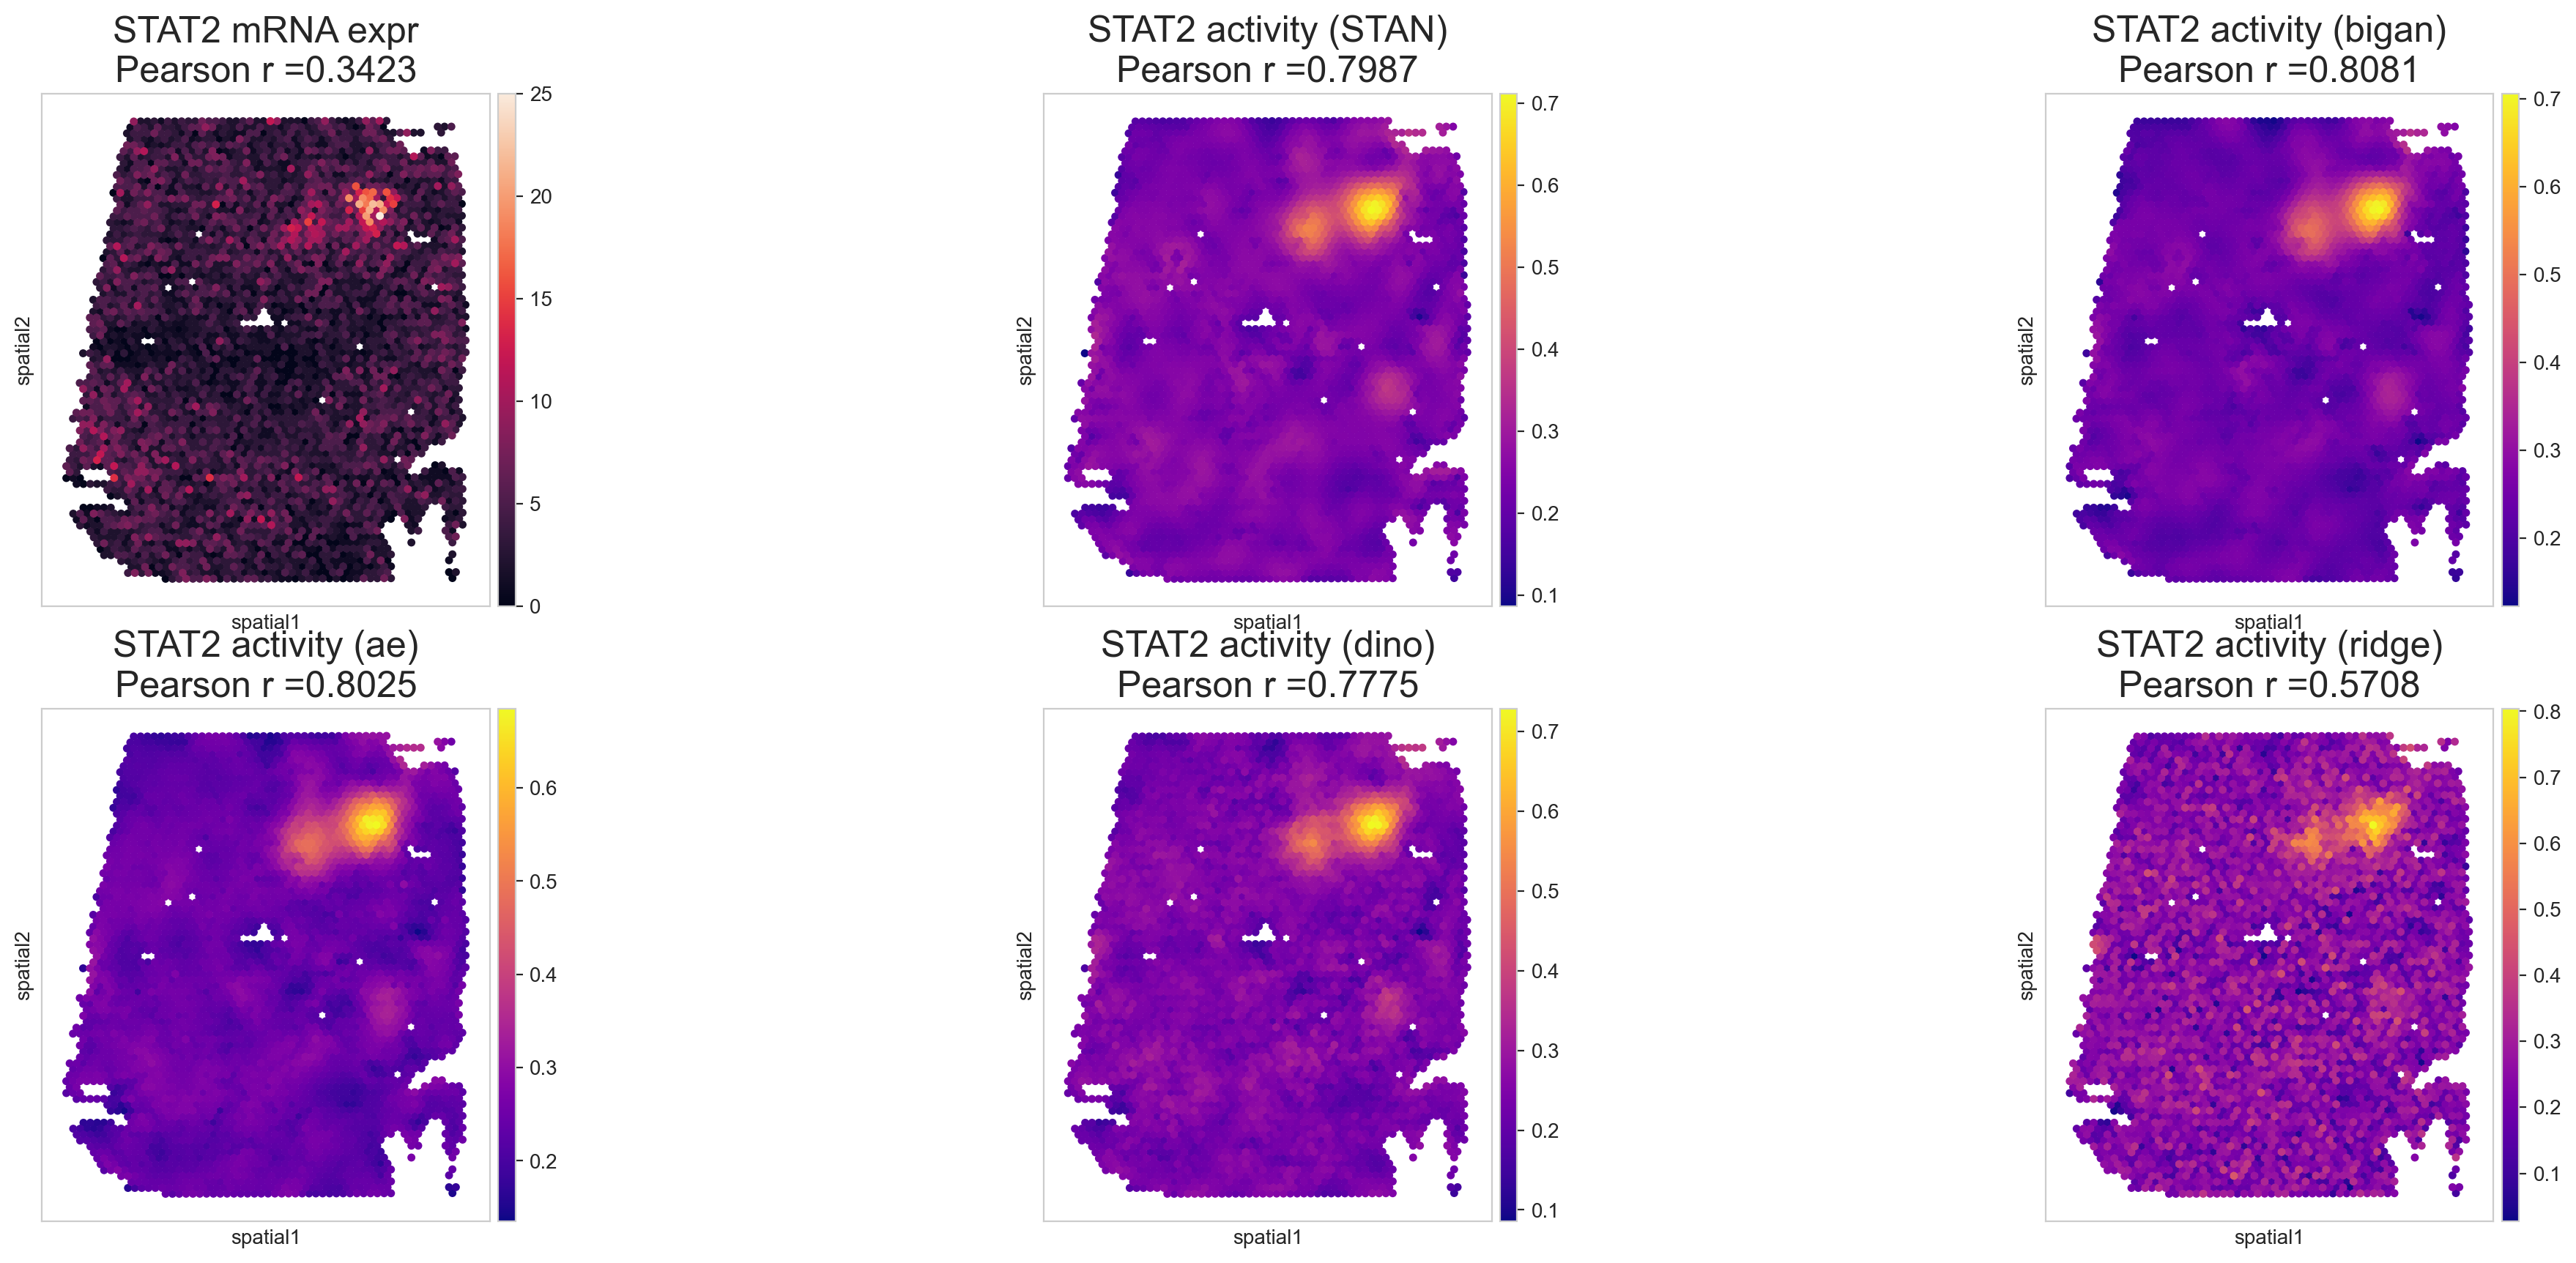

In [449]:
plot_spatial_ct_tf(ct = "B_IFN", tf = "STAT2")

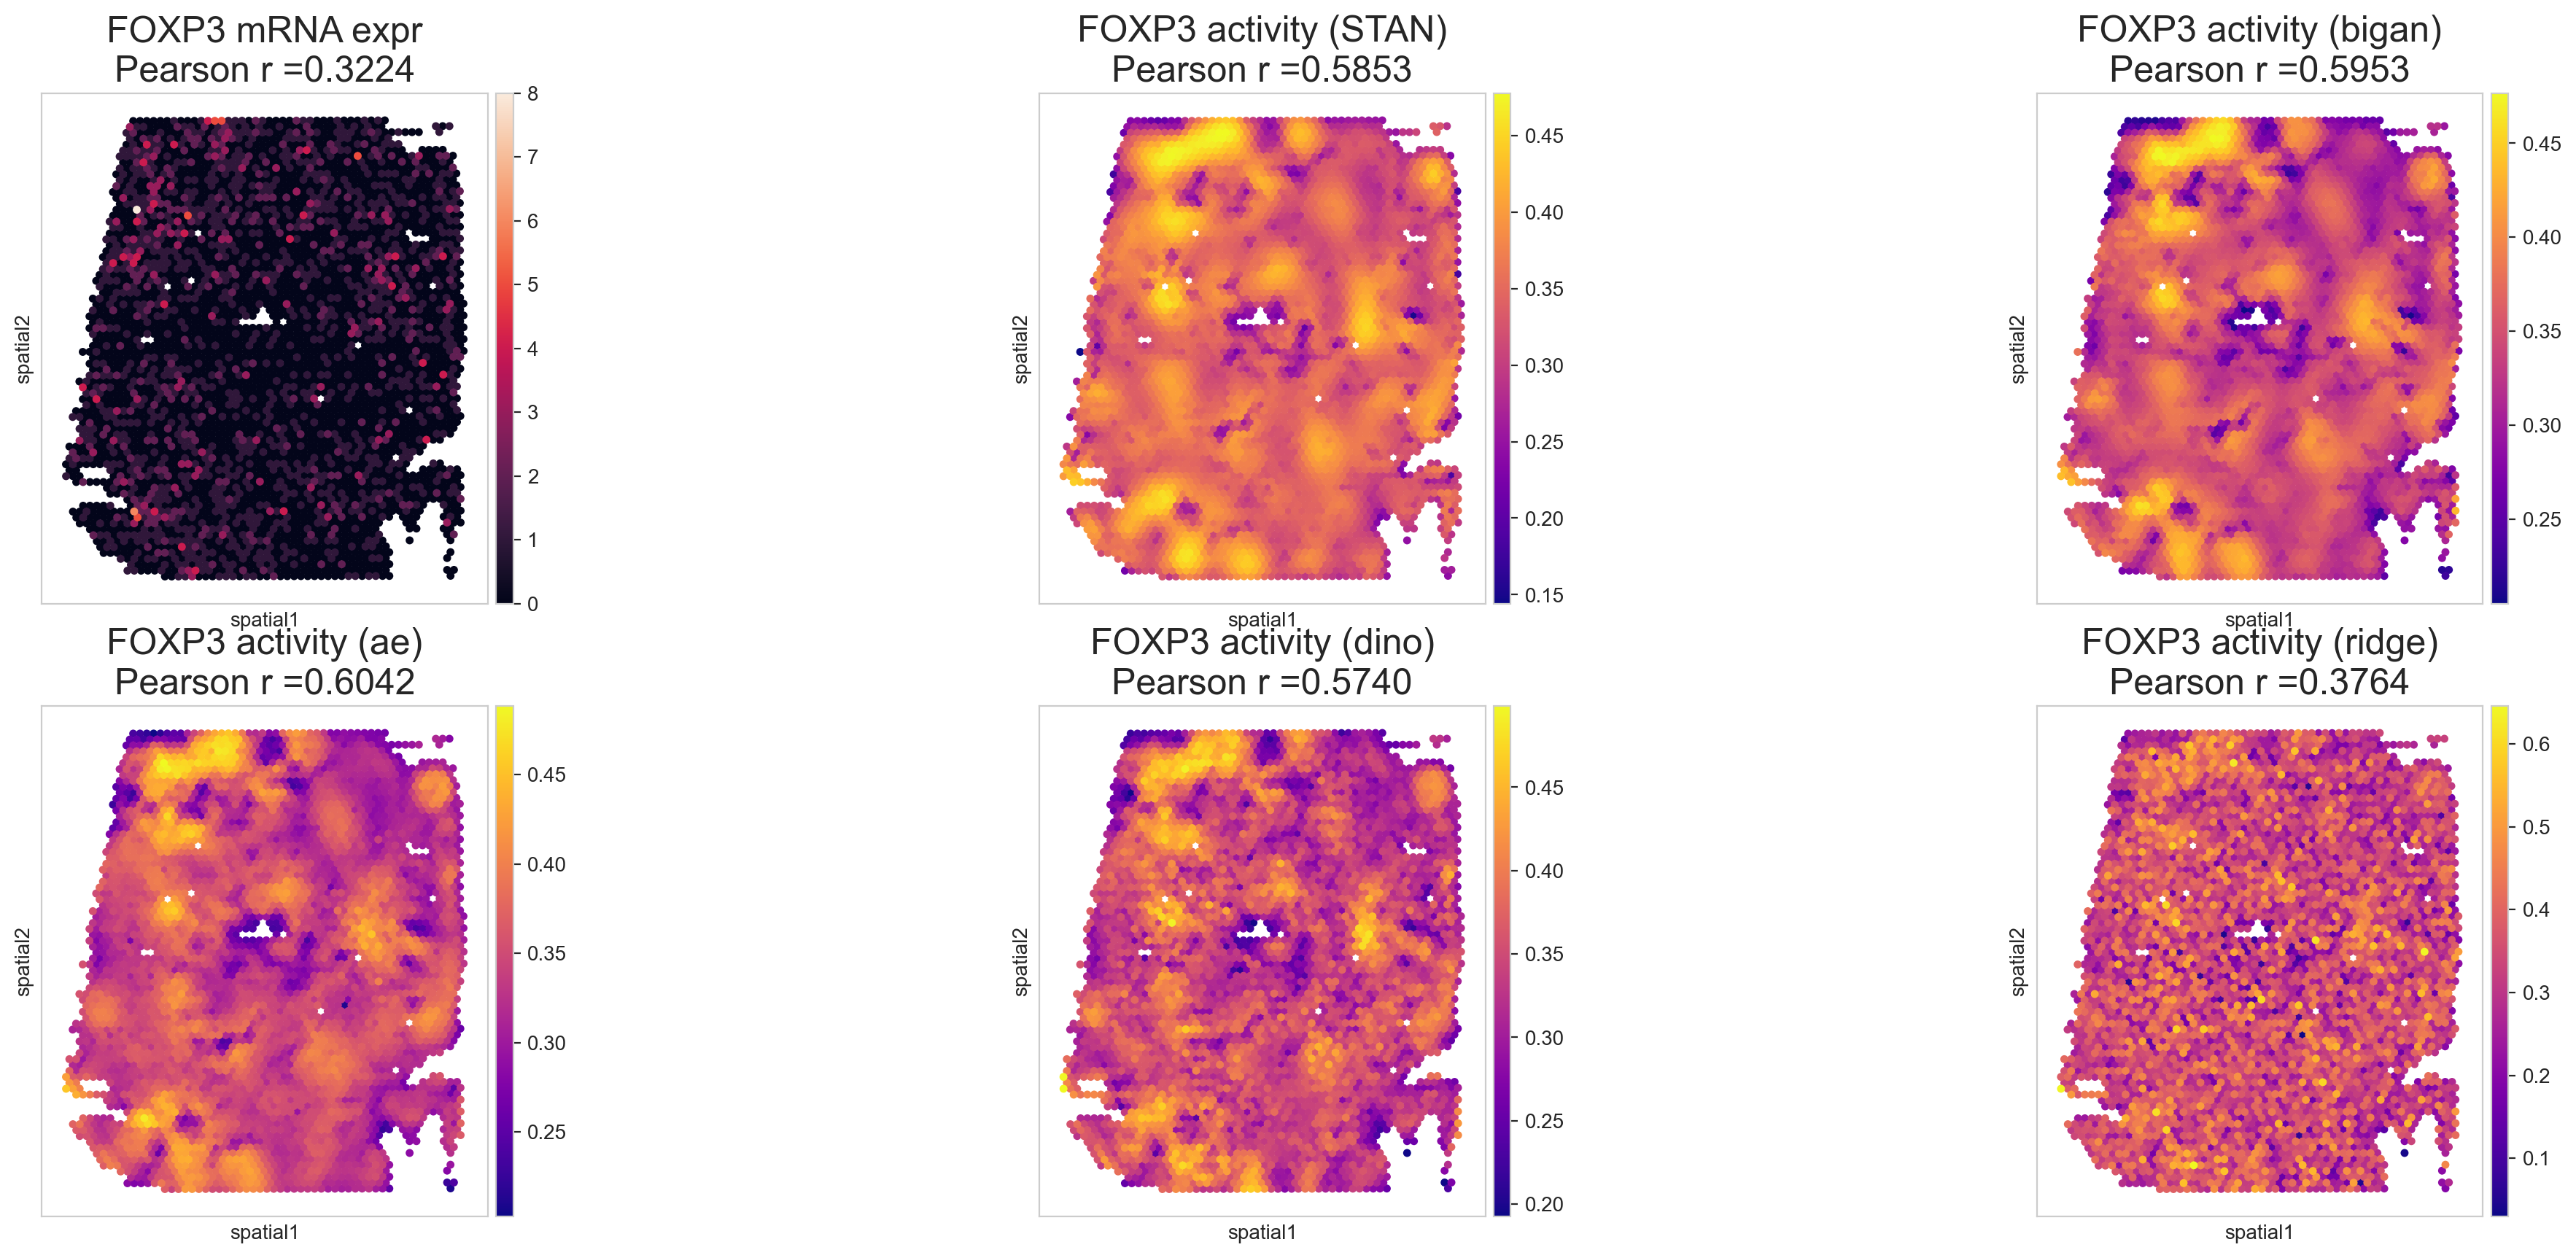

In [450]:
plot_spatial_ct_tf(ct = "T_Treg", tf = "FOXP3")